In [19]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output


In [20]:
def uniform(batchsz):
    return torch.rand(batchsz,2)

def real(batchsz):
    real_dist = np.vstack([np.random.normal([-5,-5],1.0,(21,2)),
           np.random.normal([5,5],1.0,(21,2)),
           np.random.normal([-5,5],1.0,(22,2))
                           ])
    return torch.FloatTensor(real_dist)


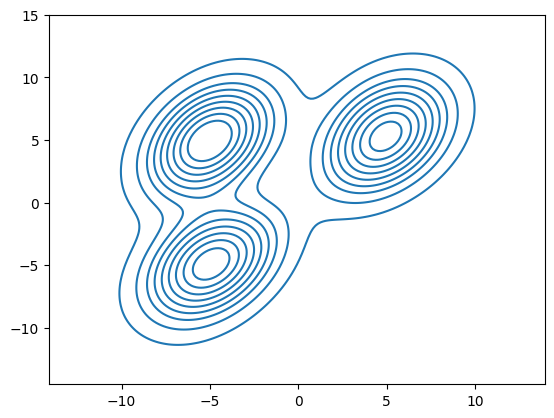

In [21]:
xy = real(64).numpy()
cmap = sns.cubehelix_palette(light=1,as_cmap=True)
sns.kdeplot(x=xy[:,0],y=xy[:,1]);

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(nn.Linear(2,16),
                                  nn.LeakyReLU(),
                                  nn.Linear(16,2))

    def forward(self,x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(nn.Linear(2,64),
                                  nn.LeakyReLU(),
                                   nn.Linear(64,32),
                                  nn.LeakyReLU(),
                                  nn.Linear(32,2),
                                  nn.Sigmoid())

    def forward(self,x):
        return self.model(x)

generator = Generator()
discriminator = Discriminator()

In [23]:
lr = 3e-3
batch_size = 64

In [24]:
gen_optm = torch.optim.Adam(generator.parameters(),lr)
disc_optm = torch.optim.Adam(discriminator.parameters(),lr)

In [25]:

def update_generator(batch_size):
    noise = uniform(batch_size)
    out = generator(noise)
    prob_fake_is_real = discriminator(out)
    loss = (- torch.log(prob_fake_is_real)).mean()

    gen_optm.zero_grad()
    loss.backward()
    gen_optm.step()
    return loss.data.numpy().item()
    
    

In [26]:
def update_discriminator(batch_size):

    # real dis
    real_dist = real(batch_size)
    prob_real_is_real = discriminator(real_dist)

    # fake dis
    noise = uniform(batch_size)
    prob_fake_is_real = discriminator(generator(noise))
    prob_fake_is_fake = 1 - prob_fake_is_real

    loss = (- torch.log(prob_real_is_real) - torch.log(prob_fake_is_fake)).mean()

    disc_optm.zero_grad()
    loss.backward()
    disc_optm.step()
    return loss.data.numpy().item()
    
    

/tmp/ipykernel_15428/2251680688.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


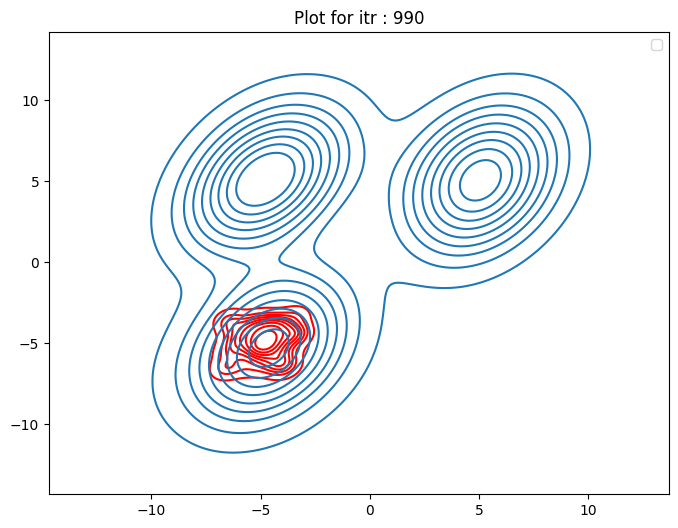

In [27]:
disc_iter = 10
for i in range(1000):
    for _ in range(disc_iter):
        update_discriminator(batch_size)
    update_generator(batch_size)

    if not i % 10:
        clear_output(True)
        plt.figure(figsize=(8,6))
        cmap = sns.cubehelix_palette(light=1,as_cmap=True)
        fake_dist = uniform(batch_size)
        real_dist = real(batch_size)
        sns.kdeplot(x = generator(fake_dist).data.numpy()[:,0],y=generator(fake_dist).data.numpy()[:,1], label="Generated Dist",color='red')
        sns.kdeplot(x = real_dist.data.numpy()[:,0],y= real_dist.data.numpy()[:,1], label="Expected Dist")

        # plt.plot(discriminator(torch.linspace(3,8,10).view(10,-1)).data.numpy()[:,0],label="Discriminator Prediction")
        
        plt.legend()
        plt.title(f'Plot for itr : {i}')
        plt.show()

### Mode collapse
 The above plot shows the training is suffering from Mode Collapse.
-  Mode collapse in the context of mixture models, such as a mixture of Gaussians, refers to a situation where the mixture model fails to capture the diversity of the data and collapses to represent only a single mode or a very limited number of modes.

